In [1]:
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/')
import numpy as np
import pandas as pd
from Cervix.run_cervix_rf import execute_cervix_rf_run

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from General_functions import plotting

import matplotlib.pyplot as plt
import seaborn as sns

from Cervix import run_cervix_rf
from debiasm import DebiasMClassifier
from General_functions.all_classification_pipelines import rescale
import torch
import torch.nn.functional as F
from main import batch_weight_feature_and_nbatchpairs_scaling
from skbio.diversity.alpha import shannon, observed_otus
from scipy.stats import wilcoxon



/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

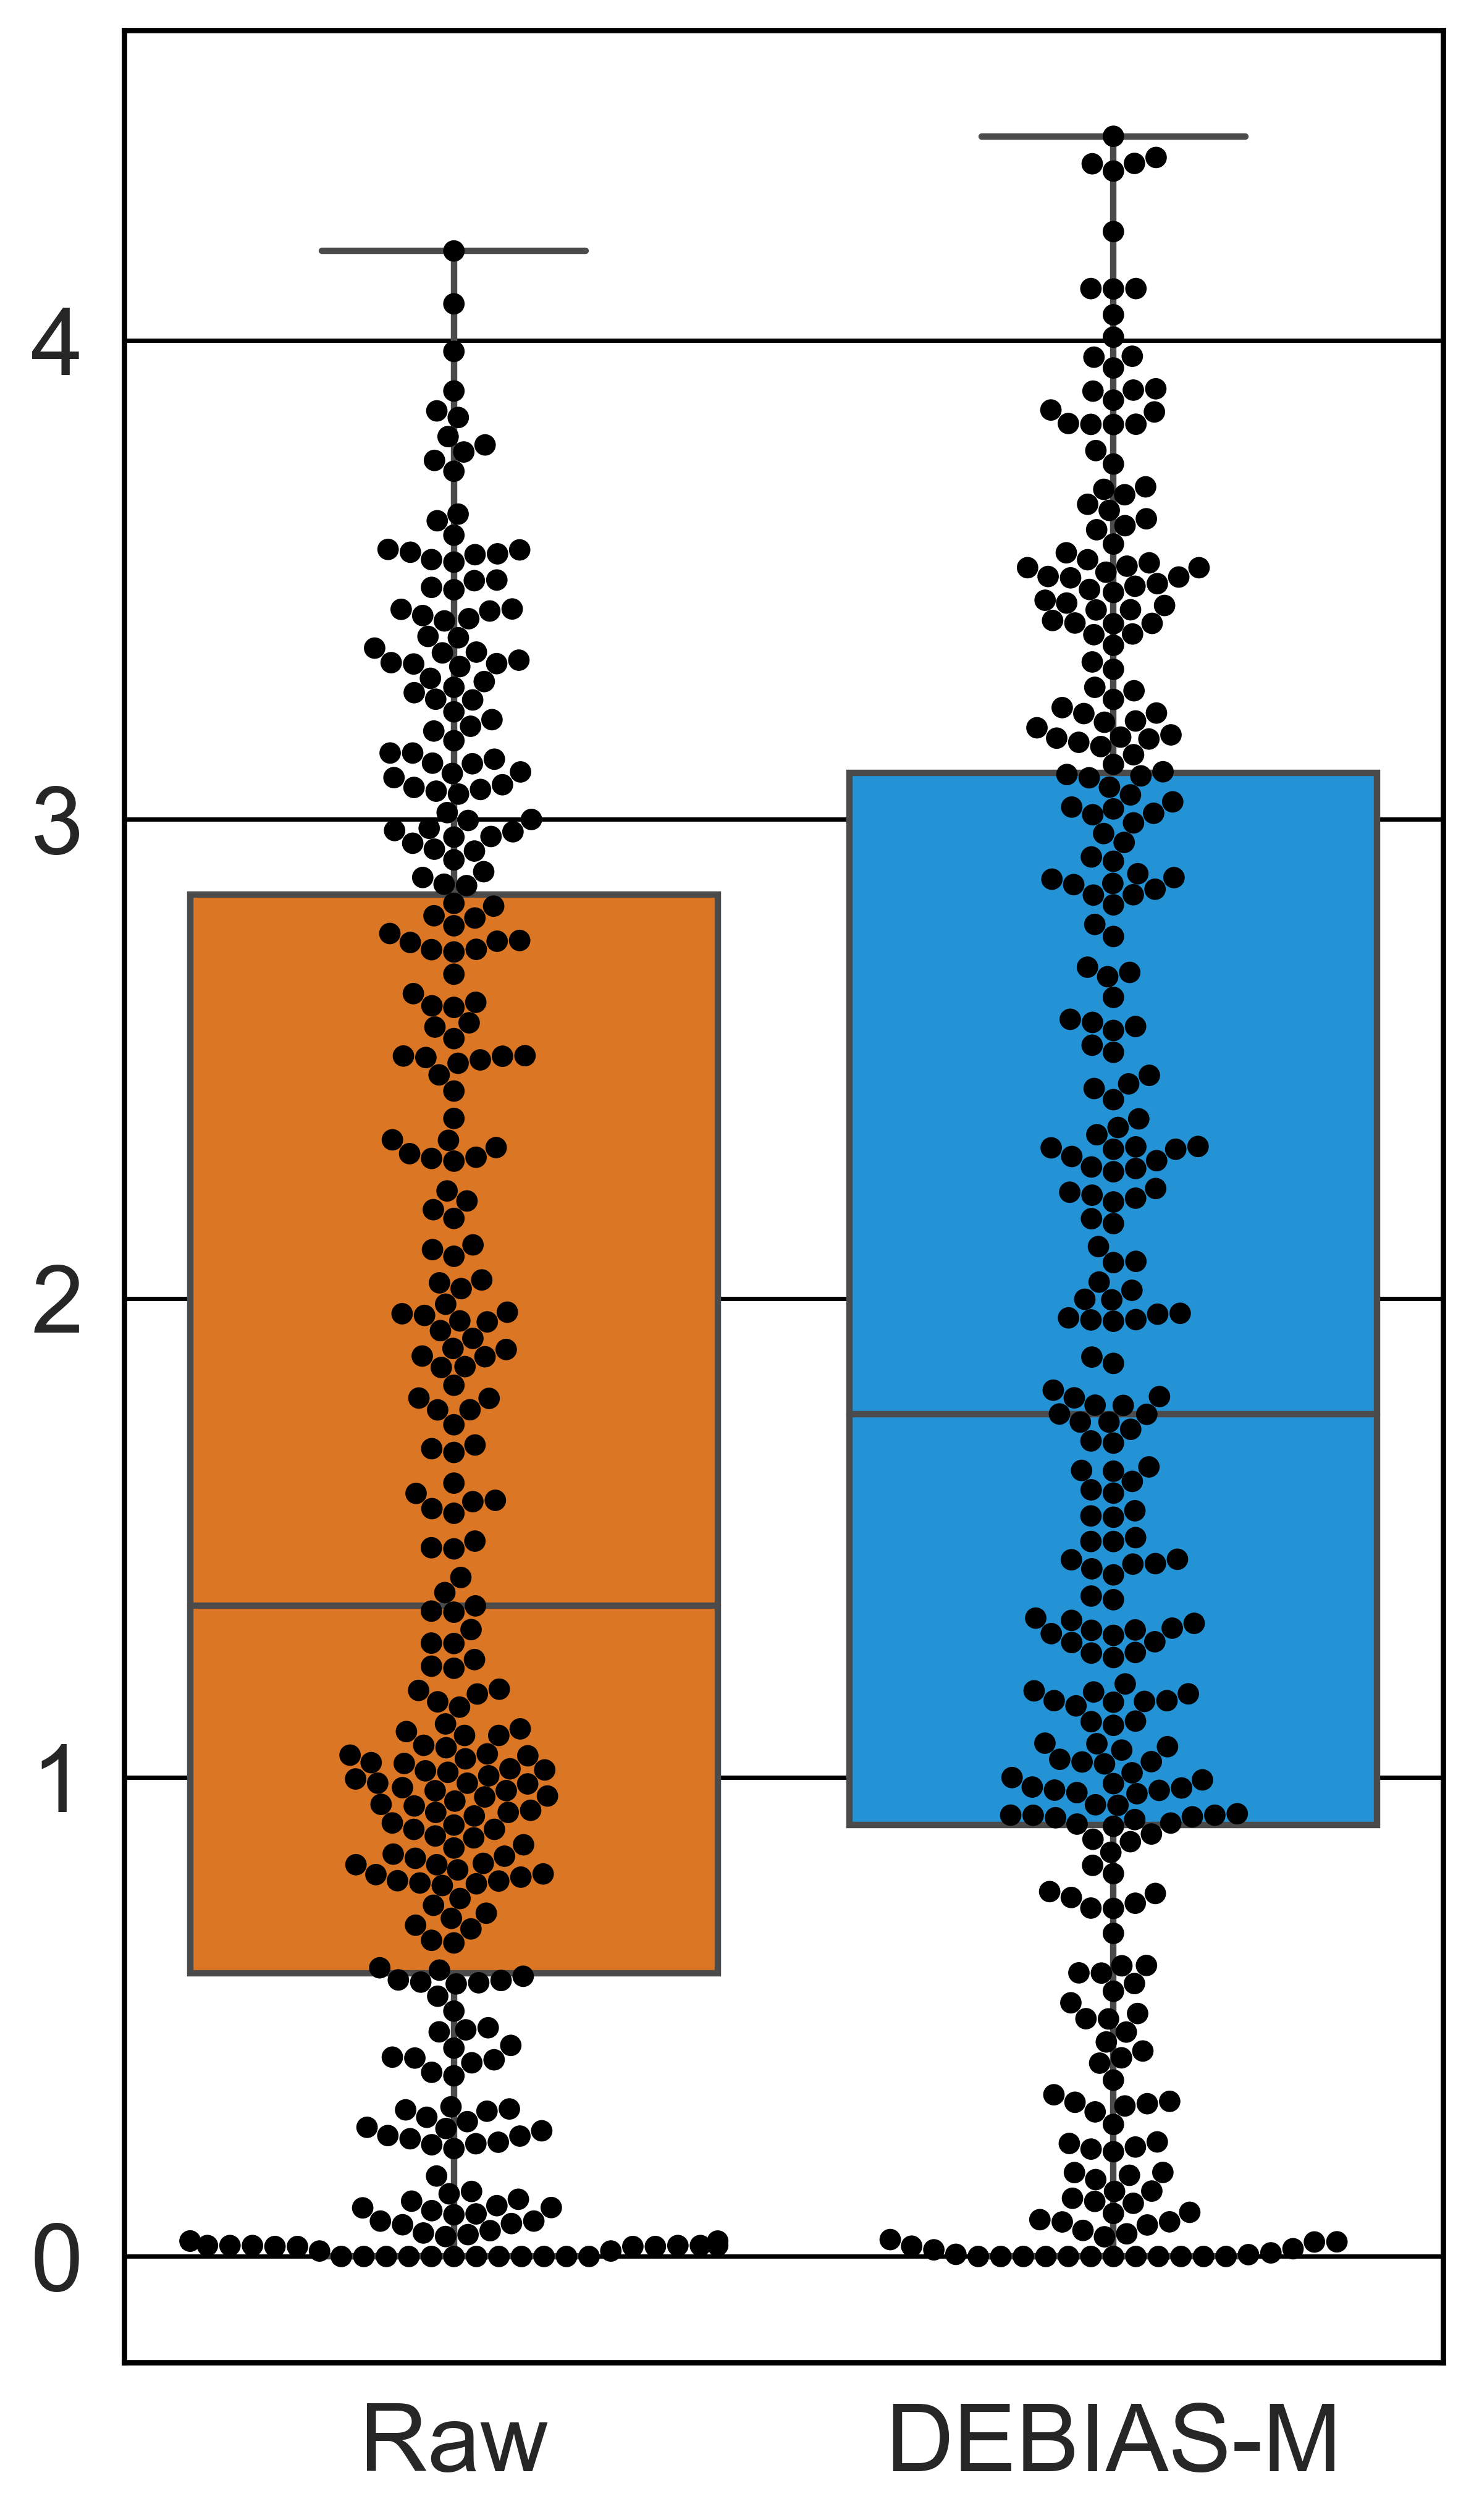

In [2]:
# ## Diversity inferences

seed=1
task='Cervix-CIN'

pal = plotting.global_palette
pal['DEBIAS-M'] = pal['debias-m']
pal['Raw'] = pal['linear']


np.random.seed(seed)
torch.manual_seed(seed)
df_, md = run_cervix_rf.load_data(task)

all_runs=[]

df_with_batch = pd.concat([pd.Series( pd.Categorical( md['Study'] ).codes, 
                                  index=md.index ),
                            df_.loc[md.index]], axis=1)

y=md[['label', 'Study']]

inds = y['label'] != -1
y=y.loc[inds]
df_with_batch = df_with_batch.loc[inds]

actual_str = batch_weight_feature_and_nbatchpairs_scaling(1e4, 
                                                          df_with_batch)

batch = df_with_batch.iloc[:, 0].unique()[0]
np.random.seed(seed)
torch.manual_seed(seed)
val_inds = df_with_batch.iloc[:, 0]==batch
X_train, X_val = df_with_batch[~val_inds], df_with_batch[val_inds]
y_train, y_val = y[~val_inds], y[val_inds]



dmc = DebiasMClassifier(batch_str = actual_str, 
                        x_val=X_val.values
                        )
dmc.fit(X_train.values, y_train.iloc[:, 0].values)

x=torch.tensor(df_with_batch.values).float()
batch_inds, x = x[:, 0], x[:, 1:]

x = F.normalize( torch.pow(2, dmc.model.batch_weights[batch_inds.long()] ) * x, p=1 )
df_wb_tmp=df_with_batch.copy()
df_wb_tmp.iloc[:,1:]=x.detach().numpy()

X_relabund = rescale( df_with_batch.iloc[:, 1:] )


x_debias = pd.DataFrame( x.detach().numpy(), 
                         columns = X_relabund.columns, 
                         index = X_relabund.index 
                        )


plt.subplots(1,
             figsize=(5.51, 10),
             dpi=500)
ax = sns.boxplot(y = [shannon(a, base=2) for a in X_relabund.values] +                 [shannon(a, base=2) for a in x_debias.values], 
            x = ['Raw']*X_relabund.shape[0] + \
                    ['DEBIAS-M'] * x_debias.shape[0], 
                 fliersize=0, 
                 palette=pal

           )

sns.swarmplot(y = [shannon(a, base=2) for a in X_relabund.values] +                 [shannon(a, base=2) for a in x_debias.values], 
               x = ['Raw']*X_relabund.shape[0] + \
                      ['DEBIAS-M'] * x_debias.shape[0], 
              color='black',
              ax=ax
           )

plt.show()

In [6]:
wilcoxon([shannon(a, base=2) for a in X_relabund.values],           
         [shannon(a, base=2) for a in x_debias.values], 
         alternative='two-sided')

WilcoxonResult(statistic=8997.0, pvalue=6.8549458572647185e-22)

In [5]:
wilcoxon([shannon(a, base=2) for a in X_relabund.values],           
         [shannon(a, base=2) for a in x_debias.values], 
         alternative='less')

WilcoxonResult(statistic=8997.0, pvalue=3.4274729286323592e-22)